In [320]:
import os
import seaborn as sns
import cv2
import random
import numpy as np
from tqdm import tqdm  # For progress bar
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta
from rich.console import Console
from rich.table import Table
from IPython.display import clear_output

import tensorflow as tf
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_CUDA_ALLOW_GROWTH"] = "true"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Enable mixed precision
#tf.keras.mixed_precision.set_global_policy('mixed_float16')

print('TensorFlow version: ',tf.__version__)
print(tf.sysconfig.get_build_info()['cuda_version'])
print(tf.sysconfig.get_build_info()['cudnn_version'])

import keras_tuner as kt
from tqdm.keras import TqdmCallback
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, AdamW
from sklearn.model_selection import train_test_split

TensorFlow version:  2.17.0
12.3
8


In [5]:
# Check if TensorFlow is built with CUDA (GPU) support
print("Built with CUDA:", tf.test.is_built_with_cuda())

# List available GPUs
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

# List the physical GPUs that TensorFlow can access
print("TensorFlow Devices: ", tf.config.list_physical_devices())

# Set memory growth to prevent TensorFlow from consuming all the GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

if physical_devices:
    # Set log device placement to True to see device assignment
    #tf.debugging.set_log_device_placement(True)

    # Example TensorFlow computation to see if GPU is used
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)

    print(c)
else:
    print("No GPU detected.")

Built with CUDA: True
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


## Helper functions

In [6]:
def load_combined_dataset(npz_path):
    """
    Loads a combined dataset (images + metadata) from a compressed .npz file.

    Args:
    - npz_path (str): Path to the saved .npz file.

    Returns:
    - dict: The loaded dataset in the original format.
    """
    data = np.load(npz_path, allow_pickle=True)
    
    # Load images
    dataset = {key: {"image": data[key]} for key in data.files if key != "metadata"}

    # Load metadata and decode JSON
    metadata = json.loads(data["metadata"].item())

    # Merge metadata back into dataset
    for key in dataset:
        if key in metadata:
            dataset[key].update(metadata[key])

    print(f"[INFO] Loaded dataset from {npz_path} with {len(dataset)} frames.")
    return dataset

In [178]:
def show_frame(dataset, frame_name, render_mode="rgb"):
    """
    Displays the specified frame along with its metadata.
    
    Args:
    - dataset (dict): Combined dataset (images + metadata).
    - frame_name (str): Name of the frame to display (e.g., "frame_0").
    - render_mode (str): "rgb" for color, "grayscale" for shades, "bw" for black & white.
    """
    if frame_name not in dataset:
        print(f"[ERROR] Frame '{frame_name}' not found in dataset.")
        return

    frame_data = dataset[frame_name]
    image = frame_data["image"]
    
    # Apply rendering mode
    if render_mode == "bw":
        image = np.where(image > 128, 255, 0)  # Convert to binary black & white
        cmap = "gray"
    elif render_mode == "grayscale":
        cmap = "gray"
    else:
        cmap = None  # RGB mode

    # Display the image
    plt.imshow(image, cmap=cmap)
    
    title = frame_name
    if "timestamp" in frame_data:
        title += f" | {frame_data['timestamp']}"

    plt.title(title)
    plt.axis("off")
    plt.show()
    
    # Print metadata
    print(f"\n[INFO] Metadata for {frame_name}:")
    
    if "timestamp" in frame_data:
        print(f"Timestamp: {frame_data['timestamp']}")
    
    print(f"Held Keys: {frame_data.get('held_keys', [])}")
    print(f"Held Keys vector: {frame_data.get('held_keys_vector', [])}")

In [8]:
def cut_dataset(dataset, start_frame, end_frame):
    """
    Trims the dataset, keeping only frames within the specified range,
    shifts frame numbering to start from 0, and adjusts timestamps using datetime.

    Args:
    - dataset (dict): The combined dataset containing images and metadata.
    - start_frame (int): The first frame number to keep (0-based index).
    - end_frame (int): The last frame number to keep.

    Returns:
    - dict: Trimmed dataset with shifted frame keys and adjusted timestamps.
    """
    # Ensure valid start and end
    if start_frame < 0:
        start_frame = 0
    if end_frame < start_frame:
        print("[ERROR] End frame must be greater than or equal to start frame.")
        return {}

    # Get valid frame keys (e.g., "frame_9", "frame_10", ..., "frame_250")
    valid_keys = [f"frame_{i}" for i in range(start_frame, end_frame + 1)]

    # Extract the reference timestamp (first frame's original timestamp)
    first_timestamp = None
    for key in valid_keys:
        if key in dataset:
            first_timestamp = datetime.strptime(dataset[key]["timestamp"], "%H:%M:%S.%f")
            break
    
    if first_timestamp is None:
        print("[ERROR] No valid frames found in the given range.")
        return {}

    # Create trimmed dataset with shifted frame names and adjusted timestamps
    trimmed_dataset = {}
    for new_index, old_key in enumerate(valid_keys):
        if old_key in dataset:
            frame_data = dataset[old_key].copy()  # Copy to avoid modifying original

            # Convert current timestamp string back to datetime
            current_timestamp = datetime.strptime(frame_data["timestamp"], "%H:%M:%S.%f")

            # Calculate new relative timestamp
            adjusted_timestamp = current_timestamp - first_timestamp
            frame_data["timestamp"] = str(adjusted_timestamp)  # Convert timedelta to string

            # Store in new dataset with updated frame key
            trimmed_dataset[f"frame_{new_index}"] = frame_data

    print(f"[INFO] Dataset cut: Kept {len(trimmed_dataset)} frames (from frame_{start_frame} to frame_{end_frame}).")
    print(f"[INFO] Frames are now renamed from frame_0 to frame_{len(trimmed_dataset) - 1}.")
    print(f"[INFO] Timestamps adjusted to start from 0.000 seconds.")

    return trimmed_dataset

In [9]:
def extract_unique_strings(parsed_metadata):
    """
    Extracts all unique strings from the parsed metadata.

    - Collects all unique 'held_keys' strings from all frames.

    Args:
    - parsed_metadata (dict): Parsed metadata from JSON.

    Returns:
    - set: Unique set of strings.
    """
    unique_strings = set()

    for frame_data in parsed_metadata.values():
        held_keys = frame_data.get("held_keys", [])
        unique_strings.update(held_keys)  # Add keys to set (automatically deduplicates)

    return unique_strings

In [10]:
def input_strings_2_binary_vectors(dataset, unique_strings):
    """
    Processes a dataset by copying images and converting held_keys into binary vectors.

    :param dataset: List of dictionaries, each containing an 'image' and 'held_keys'.
    :param unique_strings: List of all unique input keys.
    :return: Processed dataset as a new dictionary.
    """
    processed_data = {}

    # Create a mapping from input keys to binary vector indices
    key_to_index = {key: i for i, key in enumerate(sorted(unique_strings))}

    for frame_name, entry in dataset.items():
        image = entry['image']  # Copy image
        held_keys = entry.get('held_keys', [])  # Get user input keys

        # Initialize binary vector
        binary_vector = np.zeros(len(unique_strings), dtype=int)

        # Set active keys in the binary vector
        for key in held_keys:
            if key in key_to_index:
                binary_vector[key_to_index[key]] = 1

        # Store processed data in the same dictionary format
        processed_data[frame_name] = {
            'image': image,
            'held_keys_vector': binary_vector
        }

    return processed_data

In [11]:
def create_sequences(dataset_processed, sequence_length):
    """
    Creates sequences of frames from the dataset.

    :param dataset_processed: Dict of dicts, where each frame contains an image and its input data.
    :param sequence_length: The length of each sequence.
    :return: A new dictionary of sequences where each sequence contains multiple frames' images and inputs.
    """
    sequences = {}  # Dictionary to store sequences
    ordered_keys = sorted(dataset_processed.keys(), key=lambda x: int(x.split('_')[1]))  # Sort frames by number

    num_sequences = len(ordered_keys) - sequence_length + 1  # Total number of sequences that can be made
    sequence_id = 0  # Counter for sequence names

    for i in range(num_sequences):
        sequence_data = {}

        # Construct the sequence
        for j in range(sequence_length):
            frame_key = ordered_keys[i + j]
            sequence_data[f'image_{j}'] = dataset_processed[frame_key]['image']
            sequence_data[f'inputs_{j}'] = dataset_processed[frame_key]['held_keys_vector']

        sequences[f'sequence_{sequence_id}'] = sequence_data
        sequence_id += 1  # Increment sequence ID

    return sequences


In [181]:
def show_sequence(sequences, sequence_name, render_mode="rgb"):
    """
    Displays all frames in the specified sequence along with their metadata in a table.
    
    Args:
    - sequences (dict): Dictionary containing sequences of frames.
    - sequence_name (str): Name of the sequence to display (e.g., "sequence_0").
    - render_mode (str): "rgb", "grayscale", or "bw".
    """
    if sequence_name not in sequences:
        print(f"[ERROR] Sequence '{sequence_name}' not found in dataset.")
        return

    sequence_data = sequences[sequence_name]
    sequence_length = len(sequence_data) // 2  

    fig, axes = plt.subplots(1, sequence_length, figsize=(sequence_length * 3, 3))

    if sequence_length == 1:
        axes = [axes]  # Ensure axes is iterable for a single frame

    console = Console()
    table = Table(title=f"Metadata for {sequence_name}", show_lines=True)
    table.add_column("Frame", justify="center", style="bold cyan")

    for i in range(sequence_length):
        table.add_column(f"Frame {i}", justify="center")

    row_data = ["inputs"]
    for i in range(sequence_length):
        inputs_key = f"inputs_{i}"
        row_data.append(str(sequence_data[inputs_key].tolist()))

    table.add_row(*row_data)
    console.print(table)

    for i in range(sequence_length):
        image_key = f"image_{i}"
        image = sequence_data[image_key]

        if render_mode == "bw":
            image = np.where(image > 128, 255, 0)
            cmap = "gray"
        elif render_mode == "grayscale":
            cmap = "gray"
        else:
            cmap = None

        axes[i].imshow(image, cmap=cmap)
        axes[i].axis("off")
        axes[i].set_title(f"Frame {i}")

    plt.suptitle(f"Sequence: {sequence_name}")
    plt.show()


In [159]:
def generate_simulated_dataset(image_size=(224, 224), grid_size=2, color_mode="rgb", num_frames=10):
    """
    Generates a simulated dataset of a simple game environment where a ball moves in a grid.

    Args:
    - image_size (tuple): The resolution of the generated images (height, width).
    - grid_size (int): The dimensions of the grid (NxN). Default is 2x2.
    - color_mode (str): "grayscale" (black & white) or "rgb".
    - num_frames (int): Number of frames to generate.

    Returns:
    - dict: A dictionary containing generated game frames in the required format.
    """
    # Initialize dataset dictionary
    dataset = {}

    # Define movement mapping (left, right, up, down)
    movements = {
        0: (-1, 0),  # Left
        1: (1, 0),   # Right
        2: (0, -1),  # Up
        3: (0, 1)    # Down
    }

    # Define grid cell size
    cell_h, cell_w = image_size[0] // grid_size, image_size[1] // grid_size

    # Randomly initialize the ball position
    ball_x, ball_y = np.random.randint(0, grid_size), np.random.randint(0, grid_size)

    for frame in range(num_frames):
        # Create an empty game matrix
        game_matrix = np.zeros((grid_size, grid_size), dtype=int)
        game_matrix[ball_y, ball_x] = 1  # Place the ball in the matrix

        # Create a blank white image
        if color_mode == "grayscale":
            image = np.ones((image_size[0], image_size[1]), dtype=np.uint8) * 255  # White background
        else:
            image = np.ones((image_size[0], image_size[1], 3), dtype=np.uint8) * 255  # White background (RGB)

        # Draw grid lines (black lines)
        for i in range(1, grid_size):
            cv2.line(image, (0, i * cell_h), (image_size[1], i * cell_h), (0, 0, 0), 2)  # Horizontal lines
        for j in range(1, grid_size):
            cv2.line(image, (j * cell_w, 0), (j * cell_w, image_size[0]), (0, 0, 0), 2)  # Vertical lines

        if color_mode == "rgb":
            circle_color = tuple(map(int, np.random.randint(0, 255, 3)))  # Random RGB color
        else:
            circle_color = 0  # Pure black ball for grayscale

        # Draw ball in the grid
        cv2.circle(image, ((ball_x * cell_w) + cell_w // 2, (ball_y * cell_h) + cell_h // 2),
                   min(cell_w, cell_h) // 4, circle_color, -1)

        # Generate a random movement vector (left, right, up, down)
        movement_vector = np.zeros(4, dtype=int)
        move_direction = np.random.randint(0, 4)  # Choose a random movement direction
        movement_vector[move_direction] = 1

        # Compute new ball position
        new_x = ball_x + movements[move_direction][0]
        new_y = ball_y + movements[move_direction][1]

        # Ensure the ball does not go outside the grid
        if 0 <= new_x < grid_size and 0 <= new_y < grid_size:
            ball_x, ball_y = new_x, new_y

        # Store frame data
        dataset[f"frame_{frame}"] = {
            "image": image if color_mode == "rgb" else np.expand_dims(image, axis=-1),  # Keep 3D shape for grayscale
            "held_keys_vector": movement_vector
        }

    return dataset

In [452]:
def expand_input_to_feature_map(inputs, target_shape=(224, 224)):
    """
    Expands 1D binary input vectors into a 2D feature map of the given shape.

    Args:
    - inputs (numpy array): Shape (num_samples, 4), 1D binary input vectors.
    - target_shape (tuple): Desired 2D feature map shape (default: 224x224).

    Returns:
    - expanded_inputs (numpy array): Shape (num_samples, 224, 224, 1).
    """
    num_samples, num_features = inputs.shape  # e.g., (1000, 4)
    
    # Create an empty feature map
    expanded_inputs = np.zeros((num_samples, target_shape[0], target_shape[1], 1), dtype=np.float32)

    # Expand each input vector across the entire 224x224 space
    for i in range(num_samples):
        feature_map = np.tile(inputs[i].reshape(1, -1), (target_shape[0], target_shape[1] // num_features))
        expanded_inputs[i, :, :, 0] = feature_map  # Assign to the correct shape

    return expanded_inputs

## Dataset loading and manipulation

In [160]:
trial_path = "Snake/Trial_0_combined.npz"

In [393]:
test_dataset = generate_simulated_dataset(image_size=(224, 224), grid_size=2, color_mode="grayscale", num_frames=100)

In [317]:
test_dataset2 = generate_simulated_dataset(image_size=(224, 224), grid_size=2, color_mode="grayscale", num_frames=2)

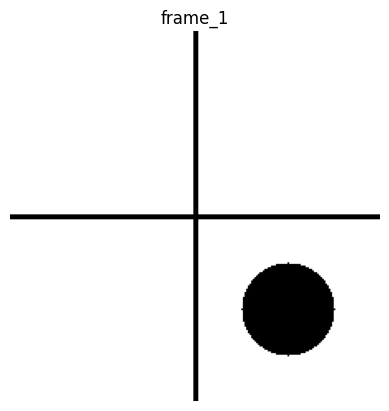


[INFO] Metadata for frame_1:
Held Keys: []
Held Keys vector: [1 0 0 0]
(224, 224, 1)


In [319]:
show_frame(test_dataset2, "frame_1", "grayscale")
print(test_dataset["frame_0"]["image"].shape)

[INFO] Loaded dataset from Snake/Trial_0_combined.npz with 431 frames.


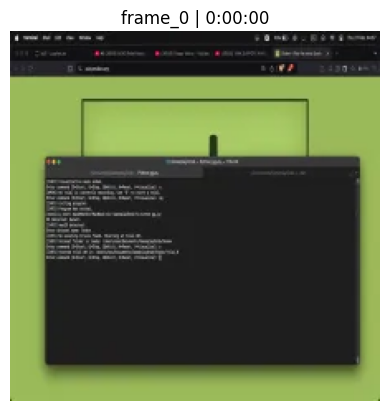


[INFO] Metadata for frame_0:
Timestamp: 0:00:00
Held Keys: []
Held Keys vector: []


In [14]:
loaded_dataset = load_combined_dataset(trial_path)

# Show a frame after loading
show_frame(loaded_dataset, "frame_0")

In [15]:
dataset = cut_dataset(loaded_dataset, 12, 413)

[INFO] Dataset cut: Kept 402 frames (from frame_12 to frame_413).
[INFO] Frames are now renamed from frame_0 to frame_401.
[INFO] Timestamps adjusted to start from 0.000 seconds.


In [16]:
unique_strings = sorted(extract_unique_strings(dataset))
# Print them sorted for better readability
print("[INFO] Unique Strings from Metadata:")
for key in sorted(unique_strings):
    print(key)
print("input signals:", len(unique_strings))

[INFO] Unique Strings from Metadata:
key.down
key.left
key.right
key.up
input signals: 4


In [17]:
dataset_processed = input_strings_2_binary_vectors(dataset, unique_strings)

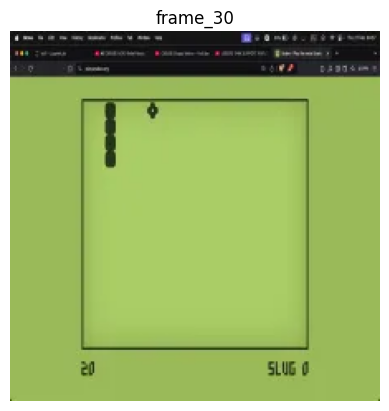


[INFO] Metadata for frame_30:
Held Keys: []
Held Keys vector: [0 0 1 0]


In [20]:
show_frame(dataset_processed, "frame_30")

In [21]:
ssl_sequences = create_sequences(dataset_processed, 2)

In [394]:
ssl_sequences = create_sequences(test_dataset, 2)

        Metadata for sequence_0         
┏━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Frame  ┃   Frame 0    ┃   Frame 1    ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ inputs │ [0, 1, 0, 0] │ [0, 0, 0, 1] │
└────────┴──────────────┴──────────────┘

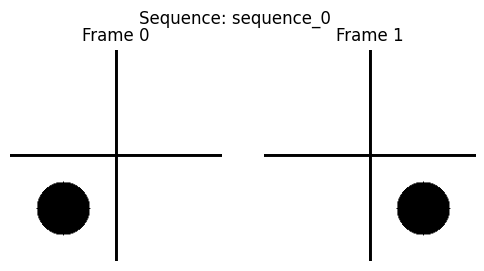

In [400]:
show_sequence(ssl_sequences, "sequence_0", "bw")

### Custom loss functions

In [218]:
def combined_loss(y_true, y_pred):
    ssim_loss_value = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    bce_loss_value = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.85 * ssim_loss_value + 0.15 * bce_loss_value

## Model build functions

In [461]:
def build_sink_model(input_shape):
    Base_input_img = Input(shape=input_shape)
    
    # ------------------------------------------------------------------------
    # Encoder
    x = Conv2D(8, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(Base_input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Bottleneck
    x = Conv2D(64, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Bottleneck_2")(x)
    x = BatchNormalization(name="Bottleneck_BatchNorm")(x)
    
    x = Conv2D(64, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Bottleneck_3")(x)
    x = BatchNormalization()(x)
    
    # Decoder
    x = Conv2D(64, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Decoder_1")(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    Base_decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    # ------------------------------------------------------------------------
    
    # Compile Model
    BaseAutoencoder = Model(Base_input_img, Base_decoded, name="Autoencoder")
    BaseAutoencoder.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.001), loss=combined_loss)
    
    # Show model summary
    BaseAutoencoder.summary()
    return BaseAutoencoder

In [219]:
def build_ssl_model3(input_shape, second_input_shape):    
    # Main Input
    Base_input_img = Input(shape=input_shape, name="Input_Image")
    
    # ------------------------------------------------------------------------
    # Encoder
    x = Conv2D(4, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Encoder_Conv1")(Base_input_img)
    x = MaxPooling2D((2, 2), padding='same', name="Encoder_MaxPool1")(x)
    
    x = Conv2D(8, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Encoder_Conv2")(x)
    x = MaxPooling2D((2, 2), padding='same', name="Encoder_MaxPool2")(x)
    
    x = Conv2D(16, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Encoder_Conv3")(x)
    x = MaxPooling2D((2, 2), padding='same', name="Encoder_MaxPool3")(x)
    
    x = Conv2D(32, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Encoder_Conv4")(x)
    x = MaxPooling2D((2, 2), padding='same', name="Encoder_MaxPool4")(x)
    
    # ------------------------------------------------------------------------
    # Bottleneck
    x = Conv2D(32, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Bottleneck_Conv1")(x)
    x = BatchNormalization(name="Bottleneck_BatchNorm1")(x)

    x = Conv2D(16, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Bottleneck_Conv2")(x)
    bottleneck = BatchNormalization(name="Bottleneck_BatchNorm2")(x)

    # ------------------------------------------------------------------------
    # SECOND INPUT & MERGE
    second_input = Input(shape=second_input_shape, name="Second_Input")

    # # Process second input into a feature map shape (14x14x<some depth>)
    second_input_dense = Dense(7 * 7 * 1, activation='sigmoid', kernel_initializer='he_normal', name="Second_Input_Dense")(second_input)
    second_input_reshaped = Reshape((7, 7, 1), name="Second_Input_Reshape")(second_input_dense)
    bottleneck_conv_input = Conv2D(16, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Decoder_Bottleneck_Conv1")(second_input_reshaped)
    upsamp = UpSampling2D((2, 2), name="Decoder_UpSample1")(bottleneck_conv_input)
    
    # Merge the processed second input with bottleneck feature maps
    merged_bottleneck = Concatenate(name="Merged_Bottleneck")([bottleneck, upsamp])
    x = BatchNormalization(name="Decoder_Bottleneck_BatchNorm")(merged_bottleneck)
    
    # ------------------------------------------------------------------------
    # Decoder
    x = Conv2DTranspose(32, (3, 3), strides=(2,2), kernel_initializer='he_normal', activation='relu', padding='same', name="Decoder_Conv1")(x)
    #x = UpSampling2D((2, 2), name="Decoder_UpSample1")(x)
    
    x = Conv2DTranspose(16, (3, 3), strides=(2,2), kernel_initializer='he_normal', activation='relu', padding='same', name="Decoder_Conv2")(x)
    #x = UpSampling2D((2, 2), name="Decoder_UpSample2")(x)
    
    x = Conv2DTranspose(8, (3, 3), strides=(2,2), kernel_initializer='he_normal', activation='relu', padding='same', name="Decoder_Conv3")(x)
    #x = UpSampling2D((2, 2), name="Decoder_UpSample3")(x)
    
    x = Conv2DTranspose(4, (3, 3), strides=(2,2), kernel_initializer='he_normal', activation='relu', padding='same', name="Decoder_Conv4")(x)
    #x = UpSampling2D((2, 2), name="Decoder_UpSample4")(x)

    # Final Output
    Base_decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="Output_Image")(x)
    
    # ------------------------------------------------------------------------
    # Model
    BaseAutoencoder = Model(inputs=[Base_input_img, second_input], outputs=Base_decoded, name="SSL_Autoencoder")
    # ------------------------------------------------------------------------
    
    # Compile Model
    BaseAutoencoder.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.001), loss=combined_loss)
    
    # Show model summary
    BaseAutoencoder.summary()
    return BaseAutoencoder

In [409]:
def build_ssl_model(input_shape, second_input_shape):    
    # Main Input
    Base_input_img = Input(shape=input_shape, name="Input_Image")
    
    # ------------------------------------------------------------------------
    # Encoder
    x = Conv2D(10, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Encoder_Conv1")(Base_input_img)
    x = MaxPooling2D((2, 2), padding='same', name="Encoder_MaxPool1")(x)
    
    x = Conv2D(10, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Encoder_Conv2")(x)
    x = MaxPooling2D((2, 2), padding='same', name="Encoder_MaxPool2")(x)
    
    x = Conv2D(15, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Encoder_Conv3")(x)
    x = MaxPooling2D((2, 2), padding='same', name="Encoder_MaxPool3")(x)
    
    x = Conv2D(15, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Encoder_Conv4")(x)
    x = MaxPooling2D((2, 2), padding='same', name="Encoder_MaxPool4")(x)
    
    # ------------------------------------------------------------------------
    # Bottleneck
    x = Conv2D(15, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Bottleneck_Conv1")(x)
    x = BatchNormalization(name="Bottleneck_BatchNorm1")(x)

    x = Conv2D(5, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Bottleneck_Conv2")(x)
    bottleneck = BatchNormalization(name="Bottleneck_BatchNorm2")(x)

    # Flatten for merging
    bottleneck_flat = Flatten(name="Bottleneck_Flatten")(bottleneck)
    # ------------------------------------------------------------------------
    # SECOND INPUT & MERGE
    second_input = Input(shape=second_input_shape, name="Second_Input")

    # Concatenate the flattened bottleneck with the second input
    merged_bottleneck = Concatenate(name="Merged_Bottleneck")([bottleneck_flat, second_input])

    # Fully connected layers
    merged_bottleneck = Dense(16, kernel_initializer='he_normal', activation='relu', name="Merged_Bottleneck_Dense1")(merged_bottleneck)
    merged_bottleneck = Dense(32, kernel_initializer='he_normal', activation='relu', name="Merged_Bottleneck_Dense2")(merged_bottleneck)
    merged_bottleneck = Dense(14 * 14 * 5, kernel_initializer='he_normal', activation='relu', name="Merged_Bottleneck_Dense3")(merged_bottleneck)

    # Reshape back to 4D for the decoder
    merged_bottleneck = Reshape((14, 14, 5), name="Merged_Bottleneck_Reshape")(merged_bottleneck)
    x = Conv2D(15, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Decoder_Bottleneck_Conv")(merged_bottleneck)
    x = BatchNormalization(name="Decoder_Bottleneck_BatchNorm")(x)

    # ------------------------------------------------------------------------
    # Decoder
    x = Conv2DTranspose(15, (3, 3), strides=(2, 2), kernel_initializer='he_normal', activation='relu', padding='same', name="Decoder_Conv1")(x)
    #x = UpSampling2D((2, 2), name="Decoder_UpSample1")(x)
    
    x = Conv2DTranspose(15, (3, 3), strides=(2, 2), kernel_initializer='he_normal', activation='relu', padding='same', name="Decoder_Conv2")(x)
    #x = UpSampling2D((2, 2), name="Decoder_UpSample2")(x)
    
    x = Conv2D(10, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Decoder_Conv3")(x)
    x = UpSampling2D((2, 2), name="Decoder_UpSample3")(x)
    
    x = Conv2D(10, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Decoder_Conv4")(x)
    x = UpSampling2D((2, 2), name="Decoder_UpSample4")(x)

    # Final Output
    Base_decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="Output_Image")(x)
    
    # ------------------------------------------------------------------------
    # Model
    BaseAutoencoder = Model(inputs=[Base_input_img, second_input], outputs=Base_decoded, name="SSL_Autoencoder")
    # ------------------------------------------------------------------------
    
    # Compile Model
    BaseAutoencoder.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.001), loss=combined_loss)
    
    # Show model summary
    BaseAutoencoder.summary()
    return BaseAutoencoder

In [249]:
def build_ssl_model2(input_shape, second_input_shape):    
    # Main Input
    Base_input_img = Input(shape=input_shape, name="Input_Image")
    
    # ------------------------------------------------------------------------
    # Encoder
    x = Conv2D(2, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Encoder_Conv1")(Base_input_img)
    x = MaxPooling2D((2, 2), padding='same', name="Encoder_MaxPool1")(x)
    
    x = Conv2D(4, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Encoder_Conv2")(x)
    x = MaxPooling2D((2, 2), padding='same', name="Encoder_MaxPool2")(x)
    
    x = Conv2D(8, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Encoder_Conv3")(x)
    x = MaxPooling2D((2, 2), padding='same', name="Encoder_MaxPool3")(x)
    
    x = Conv2D(16, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Encoder_Conv4")(x)
    x = MaxPooling2D((2, 2), padding='same', name="Encoder_MaxPool4")(x)
    
    # ------------------------------------------------------------------------
    # Bottleneck
    x = Conv2D(8, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Bottleneck_Conv1")(x)
    x = BatchNormalization(name="Bottleneck_BatchNorm1")(x)

    x = Conv2D(6, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Bottleneck_Conv2")(x)
    bottleneck = BatchNormalization(name="Bottleneck_BatchNorm2")(x)

    # Flatten for merging
    bottleneck_flat = Flatten(name="Bottleneck_Flatten")(bottleneck)

    # ------------------------------------------------------------------------
    # SECOND INPUT & MERGE
    second_input = Input(shape=second_input_shape, name="Second_Input")

    # Concatenate the flattened bottleneck with the second input
    merged_bottleneck = Concatenate(name="Merged_Bottleneck")([bottleneck_flat, second_input])

    # Fully connected layers
    merged_bottleneck = Dense(16, kernel_initializer='he_normal', activation='relu', name="Merged_Bottleneck_Dense1")(merged_bottleneck)
    merged_bottleneck = Dense(32, kernel_initializer='he_normal', activation='relu', name="Merged_Bottleneck_Dense2")(merged_bottleneck)
    merged_bottleneck = Dense(14 * 14 * 6, kernel_initializer='he_normal', activation='relu', name="Merged_Bottleneck_Dense3")(merged_bottleneck)

    # Reshape back to 4D for the decoder
    merged_bottleneck = Reshape((14, 14, 6), name="Merged_Bottleneck_Reshape")(merged_bottleneck)
    x = Conv2D(8, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same', name="Decoder_Bottleneck_Conv")(merged_bottleneck)
    x = BatchNormalization(name="Decoder_Bottleneck_BatchNorm")(x)

    # ------------------------------------------------------------------------
    # Decoder
    x = Conv2DTranspose(16, (3, 3), strides=(2,2), kernel_initializer='he_normal', activation='relu', padding='same', name="Decoder_Conv1")(x)
    
    x = Conv2DTranspose(8, (3, 3), strides=(2,2), kernel_initializer='he_normal', activation='relu', padding='same', name="Decoder_Conv2")(x)
    
    x = Conv2DTranspose(4, (3, 3), strides=(2,2), kernel_initializer='he_normal', activation='relu', padding='same', name="Decoder_Conv3")(x)
    
    x = Conv2DTranspose(2, (3, 3), strides=(2,2), kernel_initializer='he_normal', activation='relu', padding='same', name="Decoder_Conv4")(x)

    # Final Output
    Base_decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="Output_Image")(x)
    
    # ------------------------------------------------------------------------
    # Model
    BaseAutoencoder = Model(inputs=[Base_input_img, second_input], outputs=Base_decoded, name="SSL_Autoencoder")
    # ------------------------------------------------------------------------
    
    # Compile Model
    BaseAutoencoder.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.001), loss=combined_loss)
    
    # Show model summary
    BaseAutoencoder.summary()
    return BaseAutoencoder

## Data handling for training

In [449]:
# Old SSL data prep for learning, injected utoencoder architecture
# Extract images from dataset dictionary and normalize
images_0 = np.array([ssl_sequences[key]["image_0"] for key in ssl_sequences]) / 255.0
images_1 = np.array([ssl_sequences[key]["image_1"] for key in ssl_sequences]) / 255.0

# Extract input vectors
inputs = np.array([ssl_sequences[key]["inputs_0"] for key in ssl_sequences])
# inputs = np.array([ssl_sequences[key]["inputs_1"] for key in ssl_sequences])

# Concatenate input vectors for final prediction input
# concatenated_inputs = np.hstack((inputs_0, inputs_1))  # Shape: (num_samples, 18)

# Generate random binary vectors for validation & testing
rndbin_data = np.random.randint(0, 2, (images_0.shape[0], 4))

# Split into train (70%), validation (15%), and test (15%) sets
train_images_0, temp_images_0, train_images_1, temp_images_1, train_inputs, temp_inputs, train_rndbin, temp_rndbin = train_test_split(
    images_0, images_1, inputs, rndbin_data, test_size=0.3, random_state=40
)

val_images_0, test_images_0, val_images_1, test_images_1, val_inputs, test_inputs, val_rndbin, test_rndbin = train_test_split(
    temp_images_0, temp_images_1, temp_inputs, temp_rndbin, test_size=0.5, random_state=40
)

# Display dataset shapes
print("Train Images 0:", train_images_0.shape, "Train Images 1:", train_images_1.shape, "Train Inputs:", train_inputs.shape)
print("Validation Images 0:", val_images_0.shape, "Validation Images 1:", val_images_1.shape, "Validation Inputs:", val_inputs.shape)
print("Test Images 0:", test_images_0.shape, "Test Images 1:", test_images_1.shape, "Test Inputs:", test_inputs.shape)

# Prepare final dataset
X_train = [train_images_0, train_inputs]  # First input image & concatenated inputs
Y_train = train_images_1  # Target image

X_val = [val_images_0, val_inputs]
Y_val = val_images_1

X_test = [test_images_0, test_inputs]
Y_test = test_images_1

# Additional dataset for alternative input using random binary vectors
X2_val = [val_images_0, val_rndbin]

Train Images 0: (69, 224, 224, 1) Train Images 1: (69, 224, 224, 1) Train Inputs: (69, 4)
Validation Images 0: (15, 224, 224, 1) Validation Images 1: (15, 224, 224, 1) Validation Inputs: (15, 4)
Test Images 0: (15, 224, 224, 1) Test Images 1: (15, 224, 224, 1) Test Inputs: (15, 4)


In [459]:
# Extract images from dataset dictionary and normalize
images_0 = np.array([ssl_sequences[key]["image_0"] for key in ssl_sequences]) / 255.0
images_1 = np.array([ssl_sequences[key]["image_1"] for key in ssl_sequences]) / 255.0

# Extract input vectors
inputs = np.array([ssl_sequences[key]["inputs_0"] for key in ssl_sequences])
expanded_inputs = expand_input_to_feature_map(inputs)

# Generate random binary vectors for validation & testing
rndbin_data = np.random.randint(0, 2, (images_0.shape[0], 4))
expanded_rndbin = expand_input_to_feature_map(rndbin_data)

# Combine images with expanded input feature maps as a second channel
images_0_combined = np.concatenate([images_0, expanded_inputs], axis=-1)  # Shape: (num_samples, 224, 224, 2)

print("Original Image Shape:", images_0.shape)   # (num_samples, 224, 224, 1)
print("Expanded Input Shape:", expanded_inputs.shape)  # (num_samples, 224, 224, 1)
print("Combined Shape:", images_0_combined.shape)  # (num_samples, 224, 224, 2)

# Split into train (70%), validation (15%), and test (15%) sets
train_images_0, temp_images_0, train_images_1, temp_images_1 = train_test_split(
    images_0_combined, images_1, test_size=0.3, random_state=40
)

val_images_0, test_images_0, val_images_1, test_images_1 = train_test_split(
    temp_images_0, temp_images_1, test_size=0.5, random_state=40
)

# Display dataset shapes
print("Train Images 0:", train_images_0.shape, "Train Images 1:", train_images_1.shape, "Train Inputs:", train_inputs.shape)
print("Validation Images 0:", val_images_0.shape, "Validation Images 1:", val_images_1.shape, "Validation Inputs:", val_inputs.shape)
print("Test Images 0:", test_images_0.shape, "Test Images 1:", test_images_1.shape, "Test Inputs:", test_inputs.shape)

# Prepare final dataset
X_train = train_images_0  # First input image & concatenated inputs
Y_train = train_images_1  # Target image

X_val = val_images_0
Y_val = val_images_1

X_test = test_images_0
Y_test = test_images_1

Original Image Shape: (99, 224, 224, 1)
Expanded Input Shape: (99, 224, 224, 1)
Combined Shape: (99, 224, 224, 2)
Train Images 0: (69, 224, 224, 2) Train Images 1: (69, 224, 224, 1) Train Inputs: (69, 4)
Validation Images 0: (15, 224, 224, 2) Validation Images 1: (15, 224, 224, 1) Validation Inputs: (15, 4)
Test Images 0: (15, 224, 224, 2) Test Images 1: (15, 224, 224, 1) Test Inputs: (15, 4)


In [462]:
SlModel = build_sink_model((224, 224, 2))

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 2)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 8)    │           152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bottleneck_2 (Conv2D)           │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bottleneck_BatchNorm            │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bottleneck_3 (Conv2D)           │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_1 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 8)    │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 224, 224, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 197,257 (770.54 KB)

 Trainable params: 196,873 (769.04 KB)

 Non-trainable params: 384 (1.50 KB)

In [411]:
SslModel = build_ssl_model((224, 224, 1), (4, ))

Model: "SSL_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Conv1       │ (None, 224, 224,  │        100 │ Input_Image[0][0] │
│ (Conv2D)            │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_MaxPool1    │ (None, 112, 112,  │          0 │ Encoder_Conv1[0]… │
│ (MaxPooling2D)      │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Conv2       │ (None, 112, 112,  │        910 │ Encoder_MaxPool1… │
│ (Conv2D)            │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_MaxPool2    │ (None, 56, 56,    │          0 │ Encoder_Conv2[0]… │
│ (MaxPooling2D)      │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Conv3       │ (None, 56, 56,    │      1,365 │ Encoder_MaxPool2… │
│ (Conv2D)            │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_MaxPool3    │ (None, 28, 28,    │          0 │ Encoder_Conv3[0]… │
│ (MaxPooling2D)      │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Conv4       │ (None, 28, 28,    │      2,040 │ Encoder_MaxPool3… │
│ (Conv2D)            │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_MaxPool4    │ (None, 14, 14,    │          0 │ Encoder_Conv4[0]… │
│ (MaxPooling2D)      │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bottleneck_Conv1    │ (None, 14, 14,    │      2,040 │ Encoder_MaxPool4… │
│ (Conv2D)            │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bottleneck_BatchNo… │ (None, 14, 14,    │         60 │ Bottleneck_Conv1… │
│ (BatchNormalizatio… │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bottleneck_Conv2    │ (None, 14, 14, 5) │        680 │ Bottleneck_Batch… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bottleneck_BatchNo… │ (None, 14, 14, 5) │         20 │ Bottleneck_Conv2… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bottleneck_Flatten  │ (None, 980)       │          0 │ Bottleneck_Batch… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Second_Input        │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Merged_Bottleneck   │ (None, 984)       │          0 │ Bottleneck_Flatt… │
│ (Concatenate)       │                   │            │ Second_Input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Merged_Bottleneck_… │ (None, 16)        │     15,760 │ Merged_Bottlenec

 Total params: 63,050 (246.29 KB)

 Trainable params: 62,980 (246.02 KB)

 Non-trainable params: 70 (280.00 B)

### SSL training

In [417]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

In [418]:
# Train the Base Model
SslModel.fit(X_train, Y_train,
                epochs=500, batch_size=5,
                validation_data=(X_val, Y_val),
                verbose=1,
                callbacks=[early_stopping, TqdmCallback()])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0865 - val_loss: 0.0916
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0872 - val_loss: 0.0920
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0865 - val_loss: 0.0919
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0879 - val_loss: 0.0913
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0864 - val_loss: 0.0921
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0852 - val_loss: 0.0917
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0864 - val_loss: 0.0913
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0866 - val_loss: 0.0907
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0875 - val_loss: 0.0905
Epoch 10/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0861 - val_loss: 0.0901
Epoch 11/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0861 - val_loss: 0.0899
Epoch 12/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0

### SL training

In [463]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [464]:
# Train the Base Model
SlModel.fit(X_train, Y_train,
                epochs=500, batch_size=5,
                validation_data=(X_val, Y_val),
                verbose=1,
                callbacks=[early_stopping, TqdmCallback()])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/500
 1/14 ━━━━━━━━━━━━━━━━━━━━ 1:06 5s/step - loss: 0.7120

2025-02-27 15:09:07.711538: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 36 bytes spill stores, 36 bytes spill loads



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.3738

2025-02-27 15:09:10.194038: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 36 bytes spill stores, 36 bytes spill loads



14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 263ms/step - loss: 0.3676 - val_loss: 0.2683
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1903 - val_loss: 0.3008
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1410 - val_loss: 0.2899
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1026 - val_loss: 0.4023
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0832 - val_loss: 0.3480
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0796 - val_loss: 0.2674
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0793 - val_loss: 0.2359
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0696 - val_loss: 0.1742
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0728 - val_loss: 0.1258
Epoch 10/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0637 - val_loss: 0.1219
Epoch 11/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0586 - val_loss: 0.1159
Epoch 12/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0605 - val_

In [419]:
SslModel.save("POC_model.keras")

## Model validation

#### SL Model:

In [466]:
# Select 3 random samples from validation set for visualization
random_indices = random.sample(range(X_val.shape[0]), 4)
random_samples = X_val[random_indices]

random_true_samples = Y_val[random_indices]

# Reconstruct images using the trained model
reconstructed_samples = SlModel.predict(random_samples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


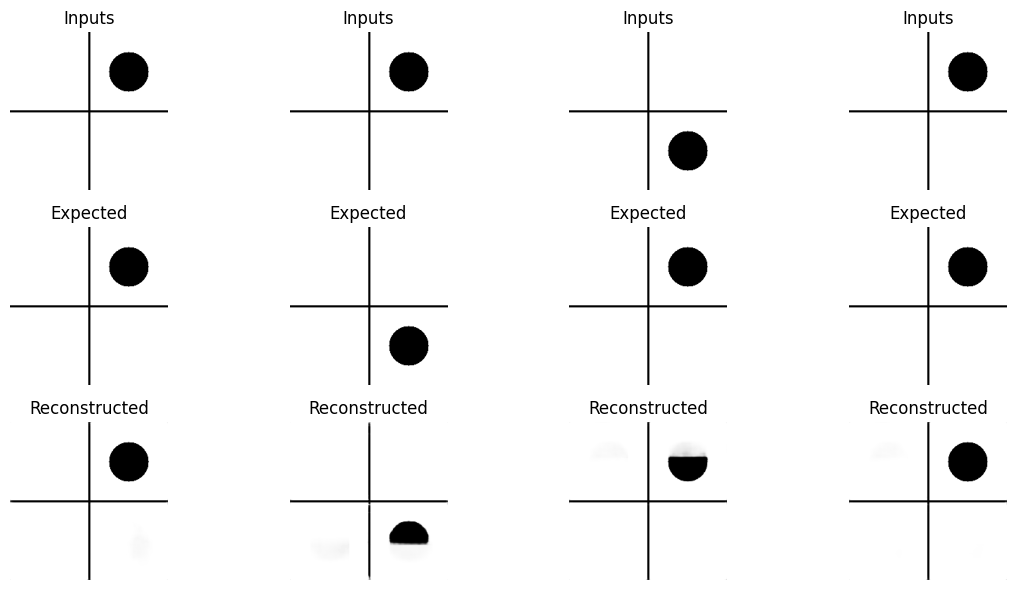

In [469]:
# Display Original and Reconstructed Images
fig, axes = plt.subplots(3, 4, figsize=(12, 6))

for i in range(4):
    # Extract first channel to ensure grayscale format
    input_img = random_samples[i][:, :, 0]  # Extract grayscale channel
    expected_img = random_true_samples[i]
    reconstructed_img = reconstructed_samples[i]

    # Original image (Inputs)
    axes[0, i].imshow(input_img, cmap="gray")  
    axes[0, i].set_title("Inputs")
    axes[0, i].axis("off")

    # True image (Expected)
    axes[1, i].imshow(expected_img, cmap="gray")
    axes[1, i].set_title("Expected")
    axes[1, i].axis("off")

    # Reconstructed image
    axes[2, i].imshow(reconstructed_img, cmap="gray")
    axes[2, i].set_title("Reconstructed")
    axes[2, i].axis("off")
    
plt.tight_layout()
plt.show()

In [426]:
# Select 4 random samples from the validation set for visualization
random_indices = random.sample(range(val_images_0.shape[0]), 4)

# Extract corresponding images and inputs
random_images_0 = val_images_0[random_indices]  # Input images
random_images_1 = val_images_1[random_indices]  # Expected output images
random_inputs_0 = val_inputs[random_indices][:, :9]  # First half of inputs (original inputs_0)
random_inputs_1 = val_inputs[random_indices][:, 9:]  # Second half of inputs (original inputs_1)
random_rndbin_samples = val_rndbin[random_indices]  # Random binary inputs

# Prepare input for model prediction (list format)
X_val_samples = [random_images_0, val_inputs[random_indices]]
X_val_samples2 = [random_images_0, random_rndbin_samples]

# Predict reconstructed images
reconstructed_samples = SslModel.predict(X_val_samples)
reconstructed_samples2 = SslModel.predict(X_val_samples2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


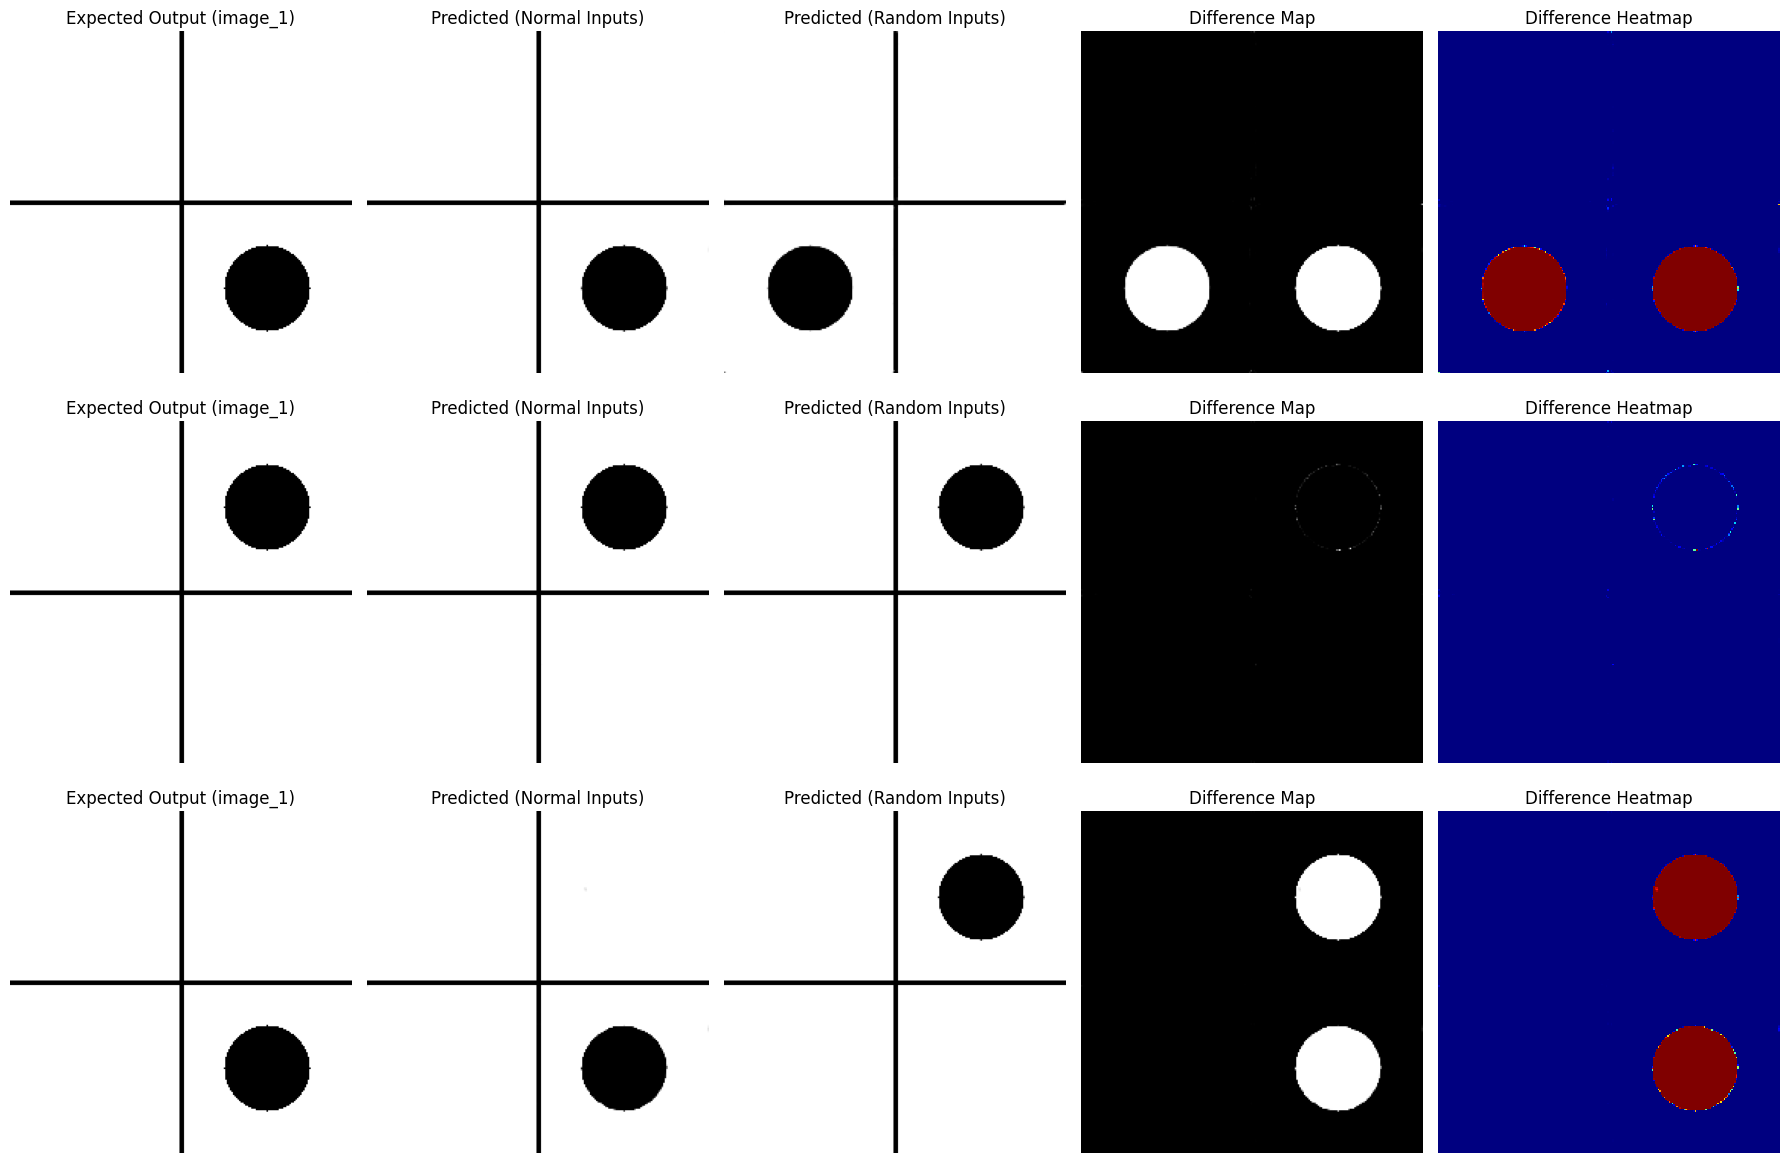

In [427]:
# Choose rendering mode: "rgb", "grayscale", or "bw"
render_mode = "grayscale"  # Change to "grayscale" or "rgb" as needed

# Create a figure with 3 rows (one for each sequence) and 5 columns
fig, axes = plt.subplots(3, 5, figsize=(18, 12))

console = Console()

for i in range(3):
    # Function to process images based on render mode
    def process_image(img):
        if render_mode == "bw":
            return np.where(img > 128, 255, 0)  # Convert to binary black & white
        elif render_mode == "grayscale":
            return np.mean(img, axis=-1) if img.shape[-1] == 3 else img  # Convert RGB to grayscale
        return img  # RGB mode

    # Process images according to render mode
    expected = process_image(random_images_1[i])
    predicted_normal = process_image(reconstructed_samples[i])
    predicted_random = process_image(reconstructed_samples2[i])

    # Display expected output image (image_1)
    axes[i, 0].imshow(expected, cmap="gray" if render_mode in ["bw", "grayscale"] else None)
    axes[i, 0].set_title("Expected Output (image_1)")
    axes[i, 0].axis("off")

    # Display predicted output using normal inputs
    axes[i, 1].imshow(predicted_normal, cmap="gray" if render_mode in ["bw", "grayscale"] else None)
    axes[i, 1].set_title("Predicted (Normal Inputs)")
    axes[i, 1].axis("off")

    # Display predicted output using random binary inputs
    axes[i, 2].imshow(predicted_random, cmap="gray" if render_mode in ["bw", "grayscale"] else None)
    axes[i, 2].set_title("Predicted (Random Inputs)")
    axes[i, 2].axis("off")

    # Compute difference
    diff = np.abs(predicted_normal - predicted_random)
    axes[i, 3].imshow(diff, cmap="gray")
    axes[i, 3].set_title("Difference Map")
    axes[i, 3].axis("off")

    # Convert difference to grayscale for heatmap
    diff_gray = np.mean(diff, axis=-1)

    # Normalize for better visualization
    diff_gray = (diff_gray - np.min(diff_gray)) / (np.max(diff_gray) - np.min(diff_gray))

    # Display heatmap
    sns.heatmap(diff_gray, cmap="jet", cbar=False, xticklabels=False, yticklabels=False, ax=axes[i, 4])
    axes[i, 4].imshow(expected, alpha=0.4)
    axes[i, 4].set_title("Difference Heatmap")
    axes[i, 4].axis("off")

    # Create metadata table for inputs
    table = Table(title=f"Inputs for Sequence {i+1}", show_lines=True)
    table.add_column("Type", justify="center", style="bold cyan")
    table.add_column("Values", justify="center")

    table.add_row("Inputs_0", str(random_inputs_0[i].tolist()))
    table.add_row("Inputs_1", str(random_inputs_1[i].tolist()))

    #console.print(table)

# Adjust layout
plt.tight_layout()
plt.show()

## Test data

In [428]:
model4testing = load_model("POC_model.keras", custom_objects={"combined_loss": combined_loss})

In [435]:
# Select 4 random samples from the validation set for visualization
random_indices = random.sample(range(val_images_0.shape[0]), 4)

# Extract corresponding images and inputs
random_images_0 = test_images_0[random_indices]  # Input images
random_images_1 = test_images_1[random_indices]  # Expected output images
random_inputs_0 = test_inputs[random_indices][:, :9]  # First half of inputs (original inputs_0)
random_inputs_1 = test_inputs[random_indices][:, 9:]  # Second half of inputs (original inputs_1)
random_rndbin_samples = test_rndbin[random_indices]  # Random binary inputs

# Prepare input for model prediction (list format)
X_test_samples = [random_images_0, test_inputs[random_indices]]
X_test_samples2 = [random_images_0, random_rndbin_samples]

# Predict reconstructed images
reconstructed_samples = model4testing.predict(X_test_samples)
reconstructed_samples2 = model4testing.predict(X_test_samples2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


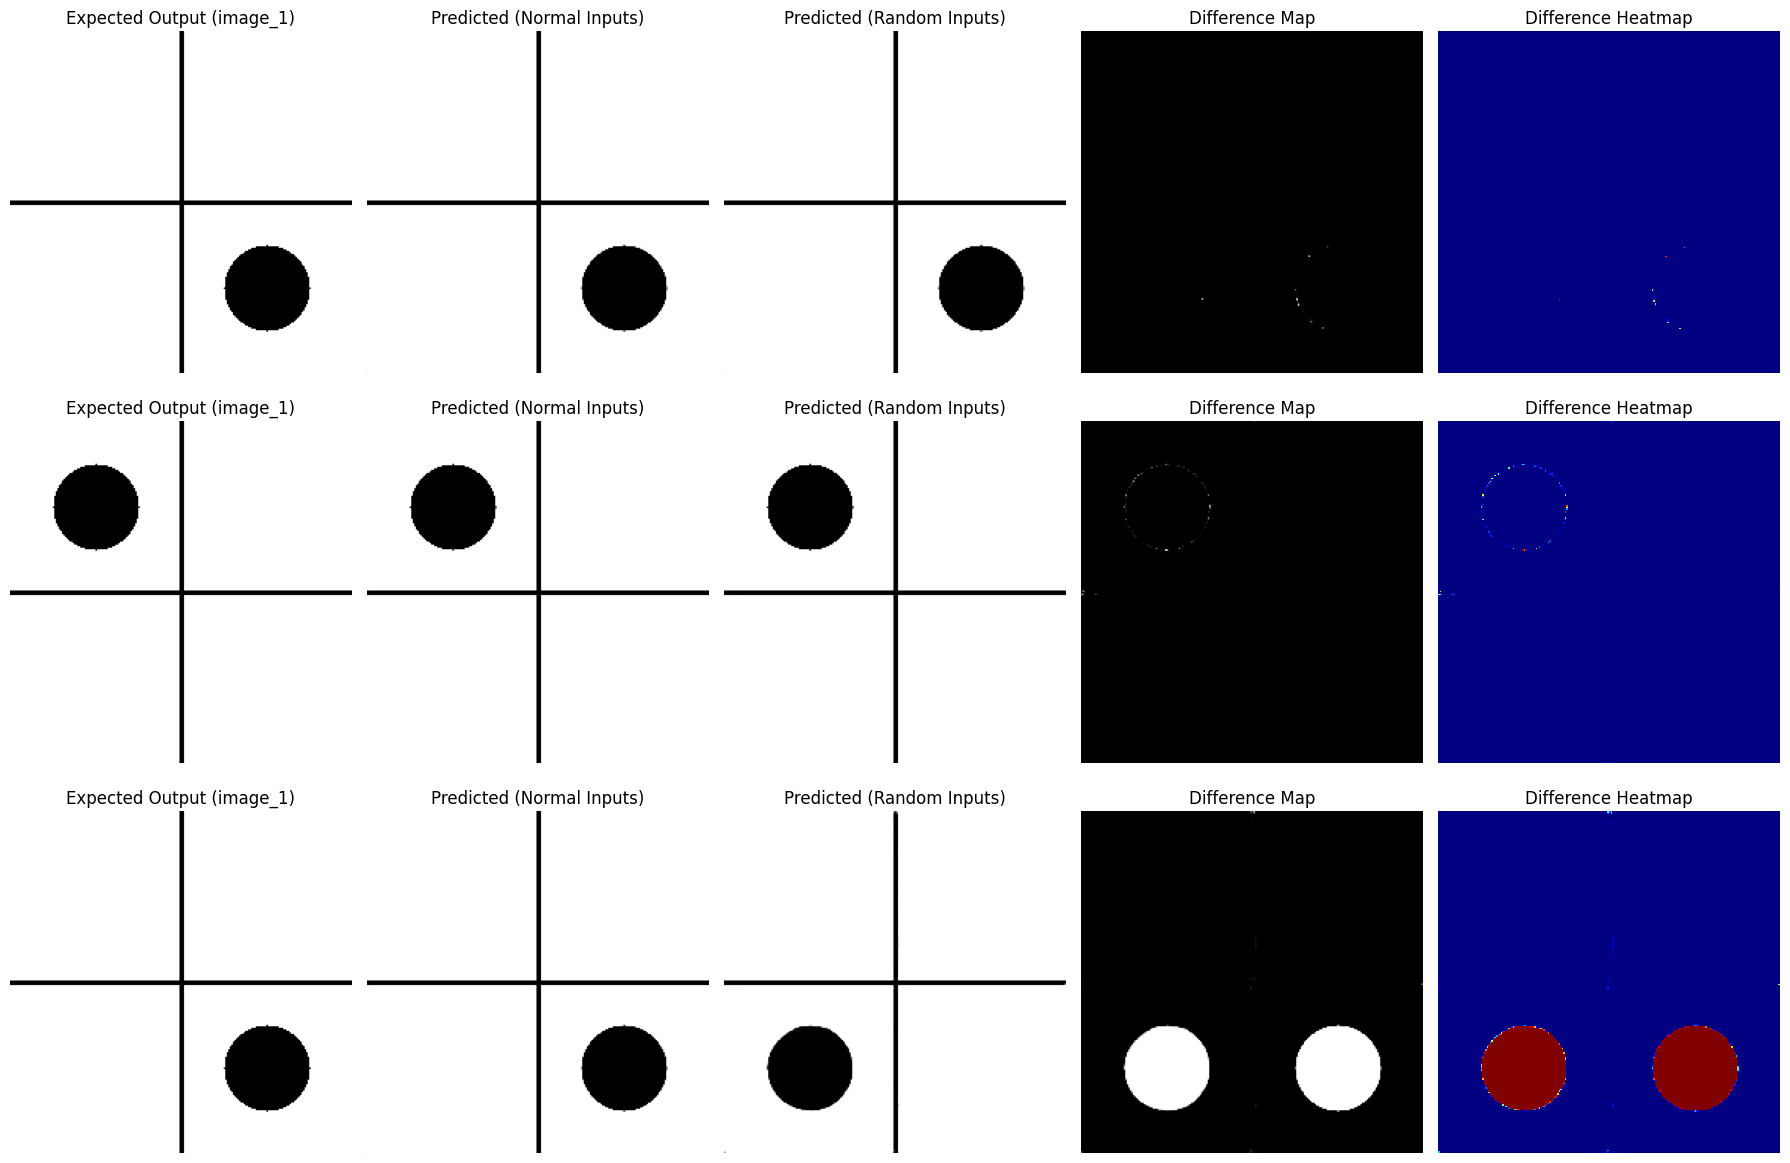

In [436]:
# Choose rendering mode: "rgb", "grayscale", or "bw"
render_mode = "grayscale"  # Change to "grayscale" or "rgb" as needed

# Create a figure with 3 rows (one for each sequence) and 5 columns
fig, axes = plt.subplots(3, 5, figsize=(18, 12))

console = Console()

for i in range(3):
    # Function to process images based on render mode
    def process_image(img):
        if render_mode == "bw":
            return np.where(img > 128, 255, 0)  # Convert to binary black & white
        elif render_mode == "grayscale":
            return np.mean(img, axis=-1) if img.shape[-1] == 3 else img  # Convert RGB to grayscale
        return img  # RGB mode

    # Process images according to render mode
    expected = process_image(random_images_1[i])
    predicted_normal = process_image(reconstructed_samples[i])
    predicted_random = process_image(reconstructed_samples2[i])

    # Display expected output image (image_1)
    axes[i, 0].imshow(expected, cmap="gray" if render_mode in ["bw", "grayscale"] else None)
    axes[i, 0].set_title("Expected Output (image_1)")
    axes[i, 0].axis("off")

    # Display predicted output using normal inputs
    axes[i, 1].imshow(predicted_normal, cmap="gray" if render_mode in ["bw", "grayscale"] else None)
    axes[i, 1].set_title("Predicted (Normal Inputs)")
    axes[i, 1].axis("off")

    # Display predicted output using random binary inputs
    axes[i, 2].imshow(predicted_random, cmap="gray" if render_mode in ["bw", "grayscale"] else None)
    axes[i, 2].set_title("Predicted (Random Inputs)")
    axes[i, 2].axis("off")

    # Compute difference
    diff = np.abs(predicted_normal - predicted_random)
    axes[i, 3].imshow(diff, cmap="gray")
    axes[i, 3].set_title("Difference Map")
    axes[i, 3].axis("off")

    # Convert difference to grayscale for heatmap
    diff_gray = np.mean(diff, axis=-1)

    # Normalize for better visualization
    diff_gray = (diff_gray - np.min(diff_gray)) / (np.max(diff_gray) - np.min(diff_gray))

    # Display heatmap
    sns.heatmap(diff_gray, cmap="jet", cbar=False, xticklabels=False, yticklabels=False, ax=axes[i, 4])
    axes[i, 4].imshow(expected, alpha=0.4)
    axes[i, 4].set_title("Difference Heatmap")
    axes[i, 4].axis("off")

    # Create metadata table for inputs
    table = Table(title=f"Inputs for Sequence {i+1}", show_lines=True)
    table.add_column("Type", justify="center", style="bold cyan")
    table.add_column("Values", justify="center")

    table.add_row("Inputs_0", str(random_inputs_0[i].tolist()))
    table.add_row("Inputs_1", str(random_inputs_1[i].tolist()))

    #console.print(table)

# Adjust layout
plt.tight_layout()
plt.show()

## Testing loop

In [437]:
model = model4testing

In [445]:
# Start inference loop
dataset = generate_simulated_dataset(image_size=(224, 224), grid_size=2, color_mode="grayscale", num_frames=1)
history = {}

frame_index = 0
current_image = dataset["frame_0"]["image"]  # Initial frame
current_inputs = dataset["frame_0"]["held_keys_vector"]
# Initial inputs

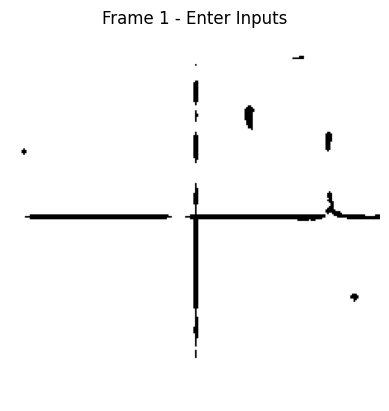

This frame inputs:  [0 0 0 0]


Enter your input vector (e.g., '0 1 0 0') or 'q' to quit:  q


Inference stopped by user.
Inference session complete. Generated dataset saved in 'history' dictionary.


In [446]:
while True:
    clear_output(wait=True)  # Clear previous output for better visualization
    
    # Display the current image
    plt.imshow(current_image.squeeze(), cmap="gray")
    plt.title(f"Frame {frame_index} - Enter Inputs")
    plt.axis("off")
    plt.show()
    
    # Get user input
    print("This frame inputs: ", current_inputs)
    user_input = input("Enter your input vector (e.g., '0 1 0 0') or 'q' to quit: ").strip()
    
    if user_input.lower() == 'q':
        print("Inference stopped by user.")
        break
    
    try:
        user_vector = np.array([int(x) for x in user_input.split()], dtype=int)
        if len(user_vector) != 4 or not np.all(np.isin(user_vector, [0, 1])):
            raise ValueError("Invalid input! Please enter exactly 4 binary values separated by spaces.")
    except ValueError as e:
        print(f"Error: {e}")
        continue
    
    # Create full input vector (4 from dataset + 4 from user)
    full_input_vector = user_vector.reshape(1, 4)
    
    # Run inference
    predicted_image = model.predict([np.expand_dims(current_image, axis=0), full_input_vector])
    
    # Convert predicted image to proper format
    predicted_image = (predicted_image.squeeze() * 255).astype(np.uint8)
    
    # Store result in history
    history[f"frame_{frame_index}"] = {
        "image": np.expand_dims(predicted_image, axis=-1),
        "held_keys_vector": full_input_vector.flatten()
    }
    
    # Update current image and inputs for next step
    current_image = np.expand_dims(predicted_image, axis=-1)
    current_inputs = user_vector  # The starting inputs for next frame
    
    frame_index += 1

# Final message
print("Inference session complete. Generated dataset saved in 'history' dictionary.")